In [1]:
!pip install pmdarima

# Importing the Necessary Libraries

import pandas as pd
from pandas import Series as Series
import numpy as np
import matplotlib.pyplot as plt  

import seaborn as sns  
import sklearn.metrics as sme
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import math
from yellowbrick.regressor import ResidualsPlot
from pmdarima.arima.utils import ndiffs

import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

import pmdarima as pm

# %matplotlib inline

     |████████████████████████████████| 1.4 MB 4.3 MB/s 


# **Importing the Train and Test Dataset**

In [2]:
ds_train = pd.read_csv("../input/ue19cs312-assignment/train.csv")
ds_train['Date'] = pd.to_datetime(ds_train.Date,format='%d-%m-%Y')
ds_train = ds_train.sort_values('Date')
ds_train_date = ds_train.set_index('Date')
ds_train_date

ds_test = pd.read_csv("../input/ue19cs312-assignment/test.csv")
ds_test['Date'] = pd.to_datetime(ds_test.Date,format='%d-%m-%Y')
ds_test = ds_test.sort_values('Date')
ds_test_date = ds_test.set_index('Date')


# **Data Visualization**

In [3]:
rcParams['figure.figsize'] = 18, 8

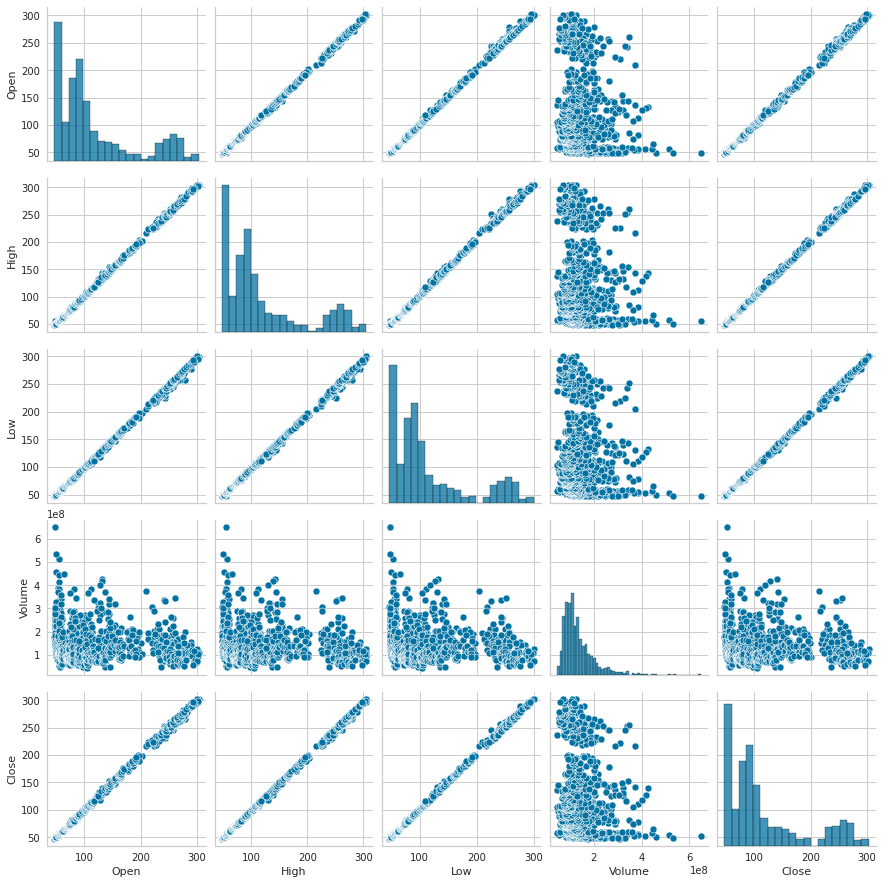

In [4]:
sns.pairplot(ds_train_date)

<AxesSubplot:>

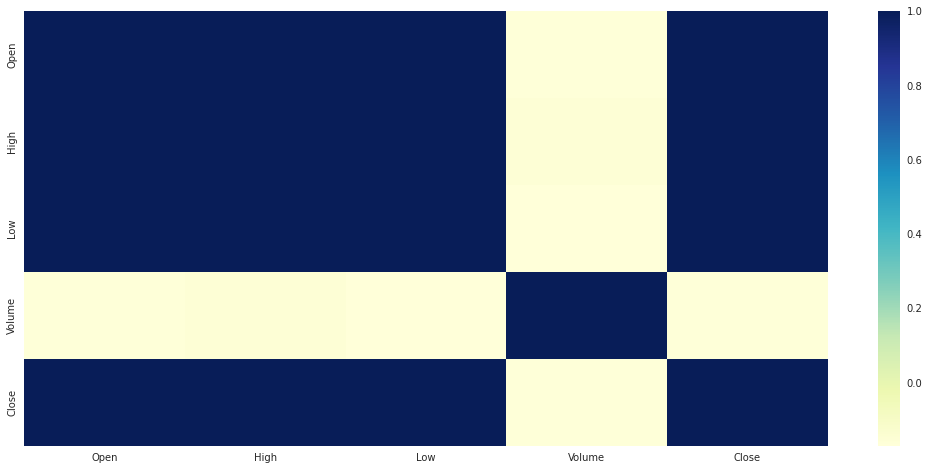

In [5]:
sns.heatmap(ds_train_date.corr(),cmap='YlGnBu')

#### **Pairplot gives us the correlation between all the variables in a dataset. It can be seen that Open, High, Low and Close have a very strong positive correlation and Volume as very low negative correlation with the others.** 

# **Regression**

Since for the given data either Regression or Time Series analysis is the most suitable method to predict the Stock prices, we start with the Regression model. For this assignment we are using Linear Regression Model.

In [6]:
xTrain = ds_train.iloc[:1400,1:4]
yTrain = ds_train.iloc[:1400,5]

In [7]:
xValid = ds_train.iloc[1400:,1:4]
yValid = ds_train.iloc[1400:,5]

xTest = ds_test.iloc[:,1:4]

In [8]:
Lr = LinearRegression(normalize = True)
Lr.fit(xTrain,yTrain)
yVPred = Lr.predict(xValid)


In [9]:
rmse = math.sqrt(sme.mean_squared_error(yVPred,yValid))
print(rmse)

1.1873984594200349


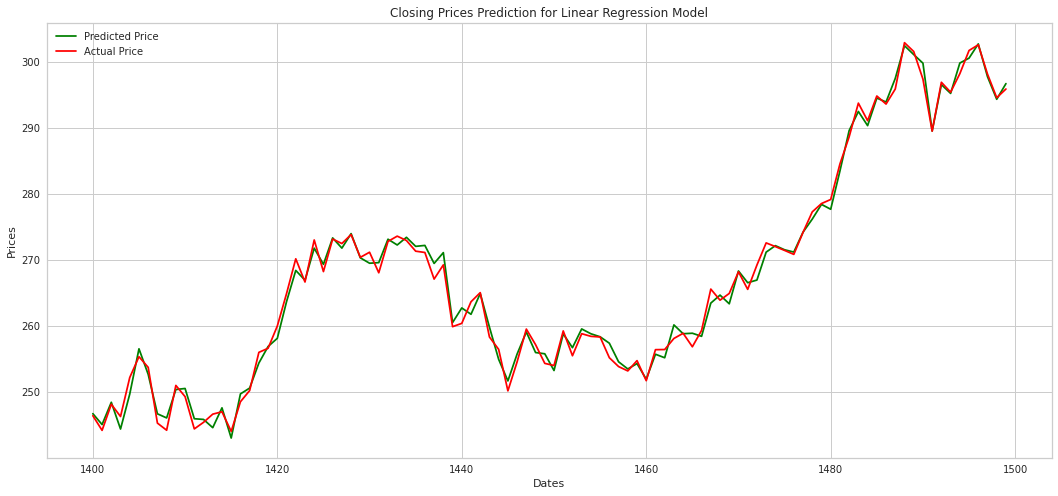

In [10]:
plt.plot(yValid.index, yVPred, color='green',label='Predicted Price')
plt.plot(yValid.index,yValid , color='red', label='Actual Price')
plt.title('Closing Prices Prediction for Linear Regression Model')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

**The Above graph gives the Actual vs the Predicted closing prices of the validation set which is obtained using the Linear Regression model.**

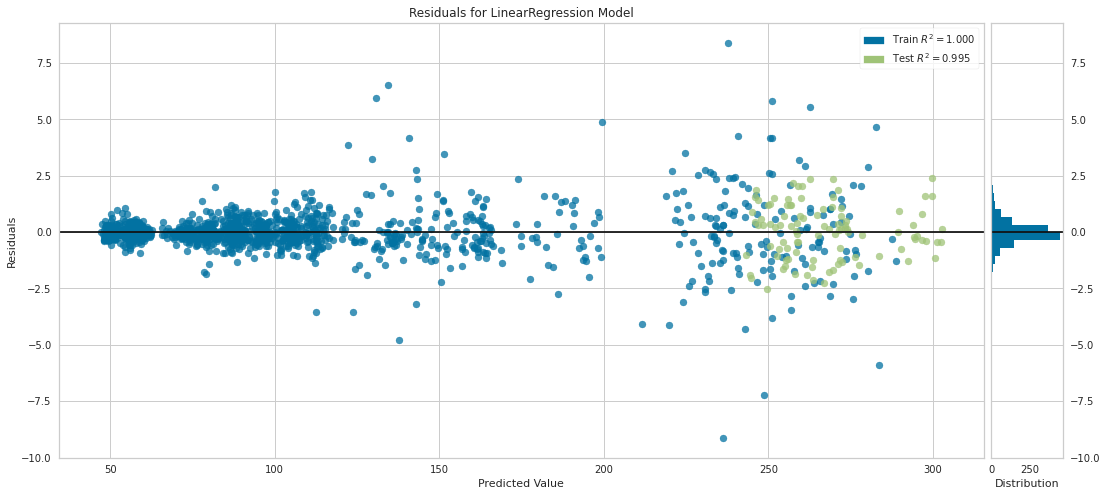

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [11]:
visualizer = ResidualsPlot(Lr)
visualizer.fit(xTrain, yTrain)  # Fit the training data to the visualizer
visualizer.score(xValid, yValid)  # Evaluate the model on the test data
visualizer.show()

In [12]:
yPred = Lr.predict(xTest)
reg_result = pd.read_csv("../input/ue19cs312-assignment/submission.csv")
reg_result['Close'] = yPred
reg_result

,Date,Close
0,30-07-2021,295.958252
1,02-08-2021,296.522874
2,03-08-2021,298.747902
3,04-08-2021,298.398693
4,05-08-2021,298.623863
5,06-08-2021,297.772247
6,09-08-2021,297.111119
7,10-08-2021,298.171329
8,11-08-2021,297.314180
9,12-08-2021,301.363251


#### **The RMSE value for the Validation set came out to be 1.187**


# **Time Series**

#### **We now use the time series models like ARMA, ARIMA and SARIMA to predict the Closing prices.**

#### **Here is the plot of the time series data for all the variables**

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

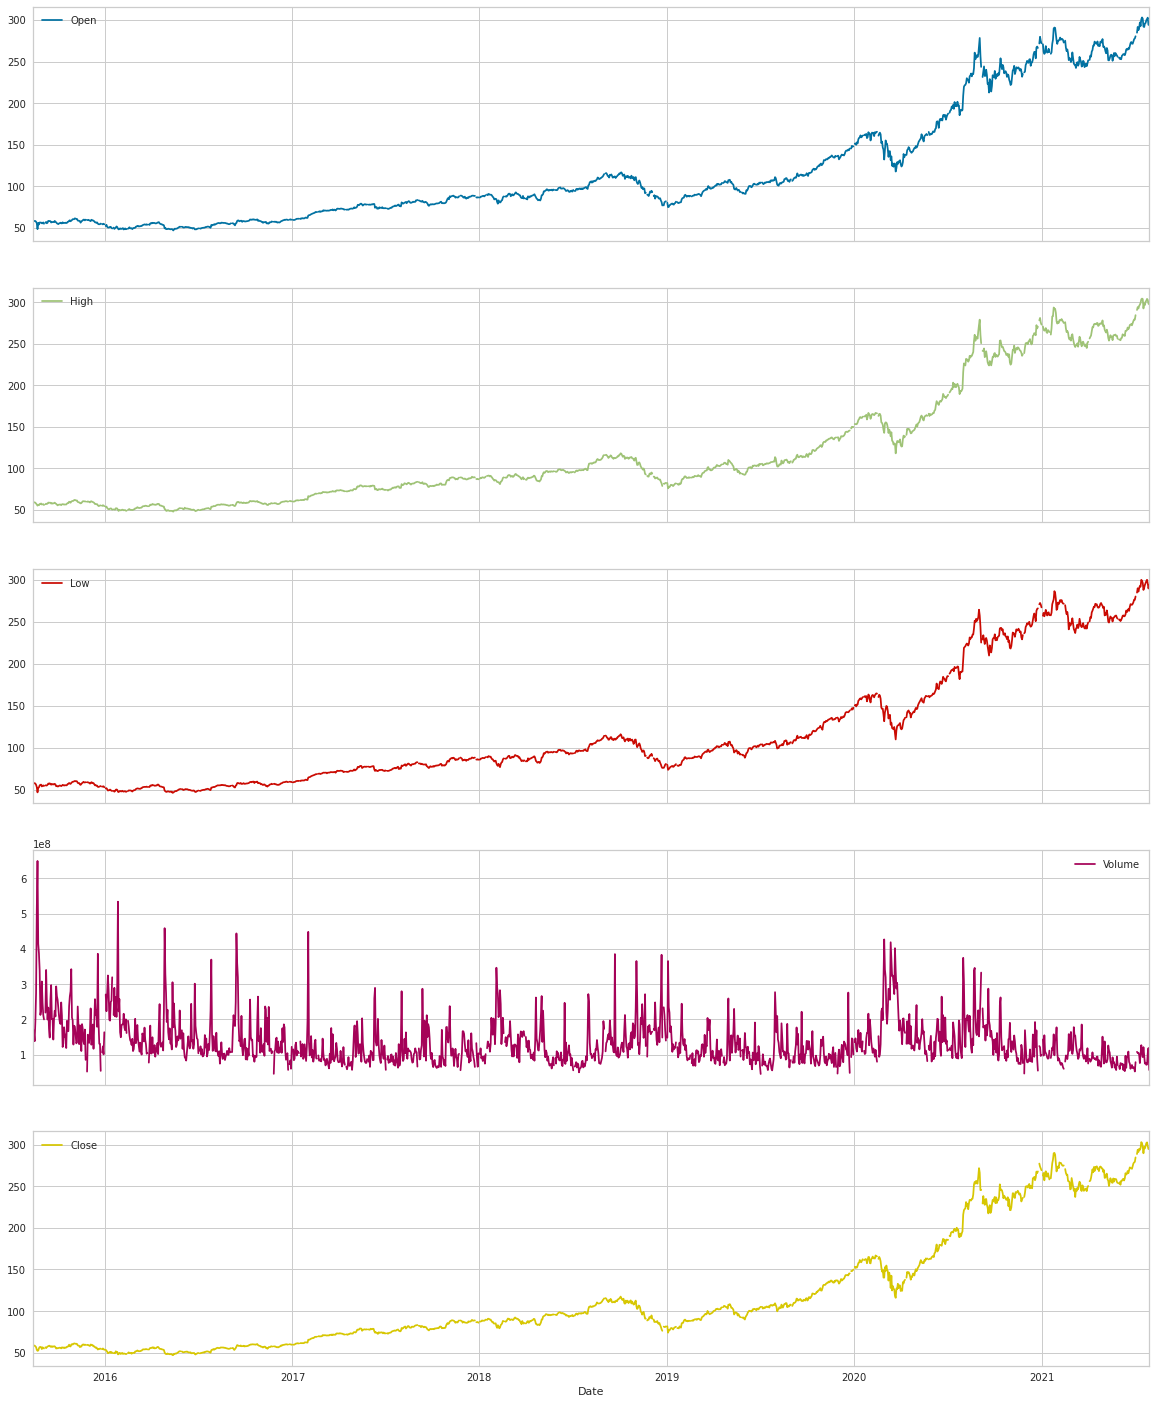

In [13]:
ds_train_date.asfreq('B').plot(subplots=True, figsize=(20,25))

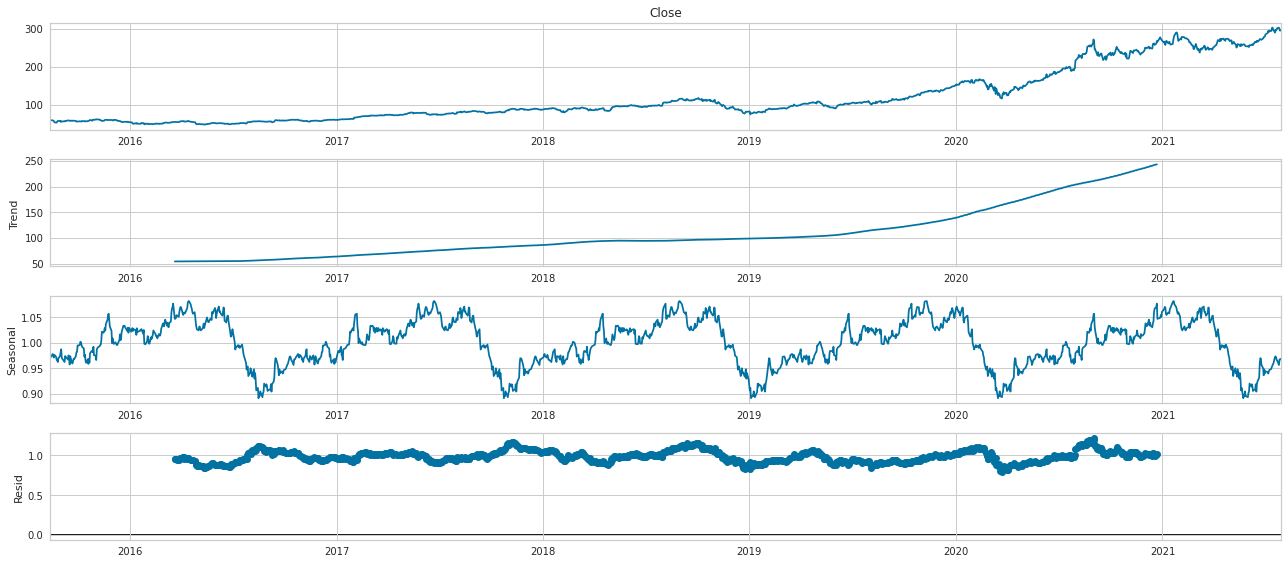

In [14]:
decomposed_a = sm.tsa.seasonal_decompose(ds_train_date["Close"],period=300,model="multiplicative") # The frequncy is annual
figure = decomposed_a.plot()
plt.show()

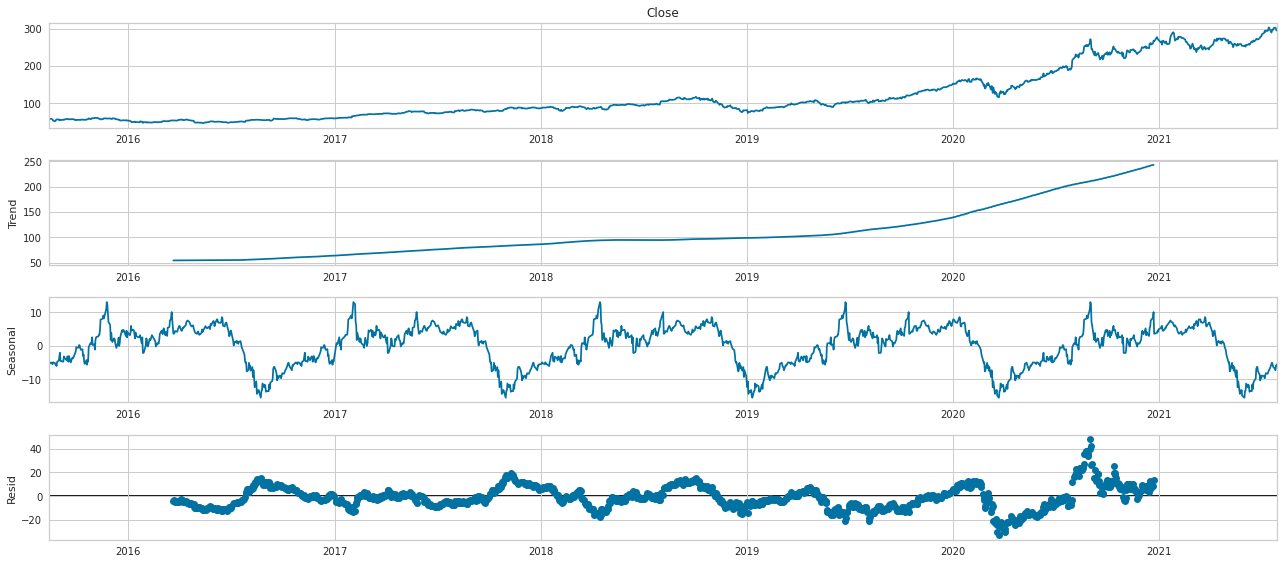

In [15]:
decomposed_a = sm.tsa.seasonal_decompose(ds_train_date["Close"],period=300,model="additive") # The frequncy is annual
figure = decomposed_a.plot()
plt.show()

#### **As the Residuals and Seasonality is independent of the Trend, the data is additive.**

### **Test for Stationarity**

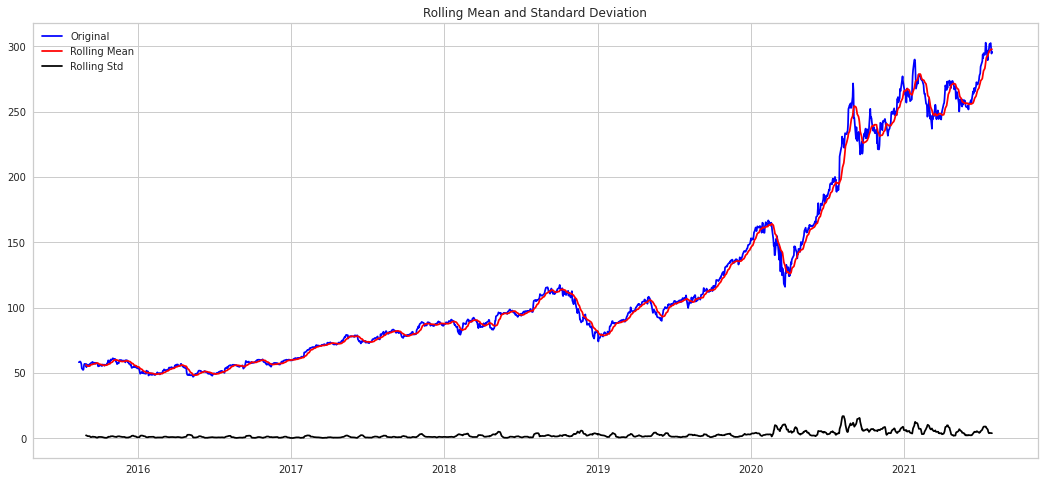

In [16]:
#Determing rolling statistics
rolmean = ds_train_date.Close.rolling(12).mean()
rolstd = ds_train_date.Close.rolling(12).std()
#Plot rolling statistics:
plt.plot(ds_train_date.Close, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

#### **After analysing the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.**

In [17]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [18]:
test_stationarity(ds_train_date['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    1.344565
p-value                           0.996847
#Lags Used                       24.000000
Number of Observations Used    1475.000000
Critical Value (1%)              -3.434791
Critical Value (5%)              -2.863501
Critical Value (10%)             -2.567814
dtype: float64


#### **Ho: It is non-stationary**

#### **H1: It is stationary**

#### **We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary. Hence we stationarise the data.**

[]

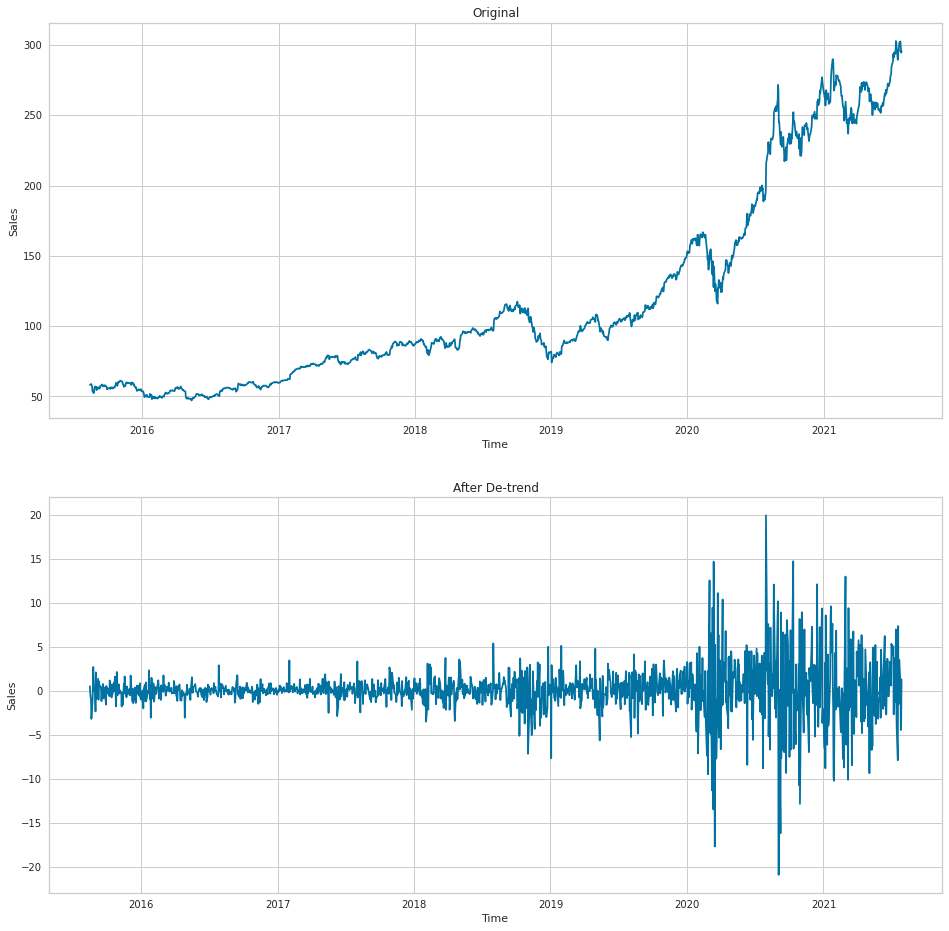

In [19]:
ts=ds_train_date.groupby(["Date"])["Close"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(211)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(212)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = ts.diff(periods=1).dropna()

plt.plot(new_ts)
plt.plot()

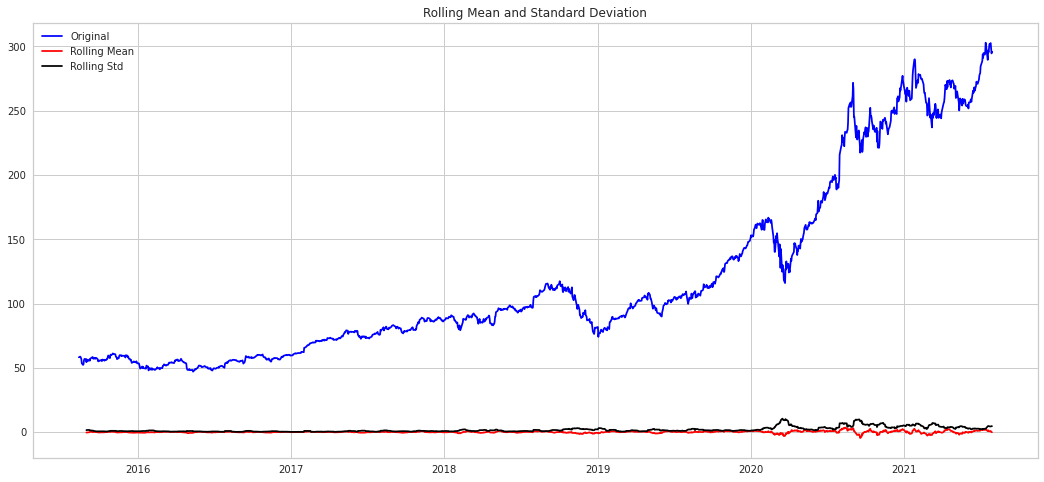

In [20]:
#Determing rolling statistics
rolmean = new_ts.rolling(12).mean()
rolstd = new_ts.rolling(12).std()
#Plot rolling statistics:
plt.plot(ds_train_date.Close, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [21]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.063762e+00
p-value                        1.616778e-12
#Lags Used                     2.300000e+01
Number of Observations Used    1.475000e+03
Critical Value (1%)           -3.434791e+00
Critical Value (5%)           -2.863501e+00
Critical Value (10%)          -2.567814e+00
dtype: float64


#### **Ho: It is non-stationary**

#### **H1: It is stationary**

#### **We see that the p-value is less than 0.05 so we reject the Null hypothesis. So the data is stationary.**

#### **The data after First Order Differencing is stationarised and is thus verified using the Rolling Statistics and the Augmented Dickey-Fuller Test.**

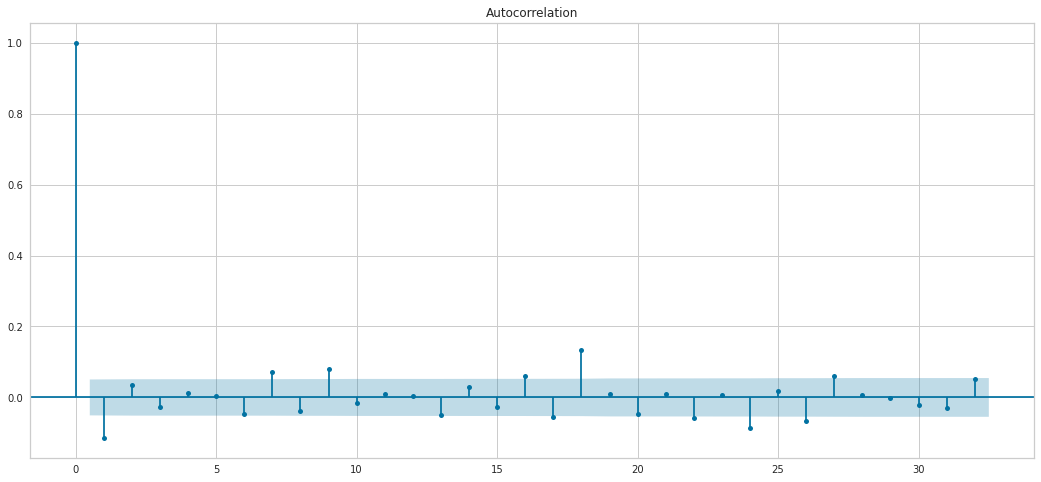

In [22]:
plot_acf(new_ts)
plt.show()

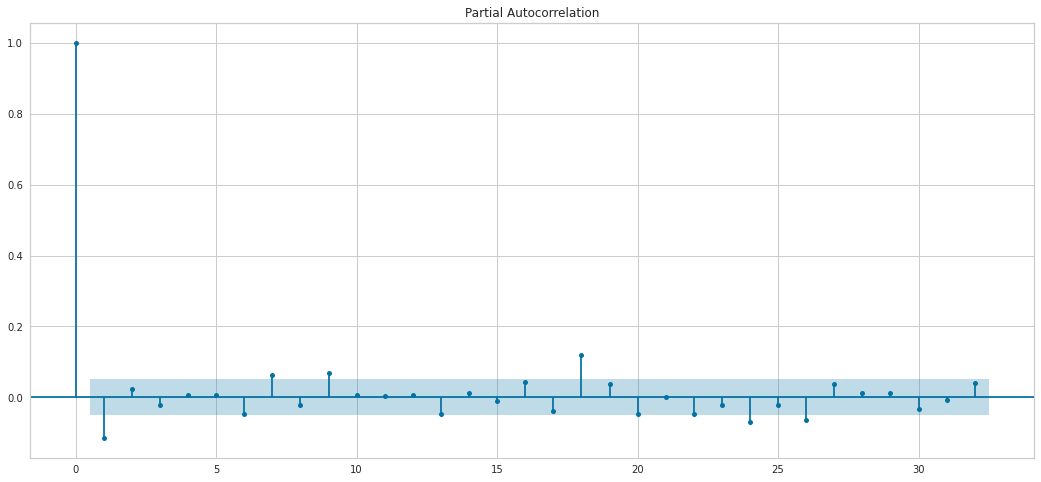

In [23]:
plot_pacf(new_ts)
plt.show()

#### **From the above plots, it can be seen that the data after de-trending as a lag of 1 in both the ACF and PACF.**

In [24]:
ndiffs(ts.values, test='adf')

1

We can see that First Order differencing removes the trend and stationarises the data and this is confirmed using the ndiffs() from the pmdarima which gives the order of differencing. This de-trends the series but we alos have to consider the seasonality of the data. So we use the SARIMA model. Since the data is Multi-variate, we have to use the SARIMAX model of the scikit library which provides an interface to use exogenous variables. We use the autoarima() of pmdarima library to obtain the (p,d,q) values and the seasonality value is set to 16 which is observed in the ETS decompostion graph.

### **SARIMAX Model**

#### **SARMIAX model internally handles all the required tasks like de-seasonalization, de-trending, etc**

In [25]:
sxmodel = pm.auto_arima(ds_train_date.iloc[:1500,-1:],exogenous = ds_train_date.iloc[:1500,:-1],
                           start_p=1, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=16,
                           start_P=0,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,n_jobs = -1,
                           random = True)

sxmodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=4590.632, Time=10.32 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=5212.572, Time=1.51 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=4829.430, Time=10.81 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=4581.148, Time=10.52 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=14564.552, Time=1.29 sec
 ARIMA(0,0,1)(0,1,0)[16] intercept   : AIC=5160.173, Time=1.83 sec
 ARIMA(0,0,1)(1,1,1)[16] intercept   : AIC=4599.945, Time=11.76 sec
 ARIMA(0,0,1)(0,1,2)[16] intercept   : AIC=4536.791, Time=26.17 sec
 ARIMA(0,0,1)(1,1,2)[16] intercept   : AIC=4544.172, Time=27.82 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=4591.709, Time=23.22 sec
 ARIMA(1,0,1)(0,1,2)[16] intercept   : AIC=4541.991, Time=27.99 sec
 ARIMA(0,0,2)(0,1,2)[16] intercept   : AIC=4532.619, Time=31.21 sec
 ARIMA(0,0,2)(0,1,1)[16] intercept   : AIC=4576.002, Time=13.45 sec
 ARIMA(0,0,2)(1,1,2)[16] intercept   : AIC=4538.167, Time=33.98 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1500
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 16)   Log Likelihood               -2253.774
Date:                                 Sat, 06 Nov 2021   AIC                           4527.548
Time:                                         17:23:06   BIC                           4580.573
Sample:                                              0   HQIC                          4547.313
                                                - 1500                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0130      0.005     -2.460      0.014      -0.023      -0.003
Open          -0.5742      0.004   -138.837      0.000      -0.582      -0.566
High           0.8778      0.002    487.541      0.000       0.874       0.881
Low            0.6971      0.006    120.766      0.000       0.686       0.708
Volume     -2.198e-09   4.19e-10     -5.250      0.000   -3.02e-09   -1.38e-09
ar.L1         -0.1904      0.006    -29.555      0.000      -0.203      -0.178
ar.L2         -0.1209      0.004    -31.117      0.000      -0.129      -0.113
ma.S.L16      -0.7803      0.001   -535.156      0.000      -0.783      -0.777
ma.S.L32      -0.0601      0.001    -64.262      0.000      -0.062      -0.058
sigma2         1.8661      0.002   1014.969      0.000       1.862       1.870
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):             11431.96
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              29.07   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+17. Standard errors may be unstable.
"""

In [26]:
ds_sub = pd.read_csv("../input/ue19cs312-assignment/submission.csv")
f = pd.concat([ds_sub, pd.DataFrame(sxmodel.predict(n_periods = len(ds_test_date.iloc[:,-1:]), exogenous = ds_test_date.iloc[:,:-1]))],axis = 1)
f.set_axis(['Date', 'Close'],axis = 1, inplace = True)
# f.to_csv('submission.csv',index = False)
f

,Date,Close
0,30-07-2021,296.570240
1,02-08-2021,296.085791
2,03-08-2021,298.854442
3,04-08-2021,297.953610
4,05-08-2021,298.481242
5,06-08-2021,297.762658
6,09-08-2021,296.741535
7,10-08-2021,298.054546
8,11-08-2021,297.442550
9,12-08-2021,301.393189


In [27]:
yPredS = sxmodel.predict(n_periods = len(ds_train_date.iloc[1400:,-1:]), exogenous = ds_train_date.iloc[1400:,:-1])

In [28]:
rmse = math.sqrt(sme.mean_squared_error(ds_train_date.iloc[1400:,-1:], yPredS ))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.2150129893533856.


### We proceed to use Time Series Models like ARMA, ARIMA and SARIMA because in regression models the variables are considered to be features and the target variable(Close in this case) is dependent on all the other variables whereas actually the variables 'Open', 'High', 'Low' and 'Volume' are exogenous to the system. Hence using a time series model on the given dataset would be more appropriate.

### Both the Linear Regression and the SARIMAX models were submitted to the portal and the RMSE value on the test data for the SARIMAX turned out to be lower than the linear regression model, hence the SARIMAX model performs better than the linear regression model on the test set whereas the regression model performs better on the validation set. Therefore our decision to work on the time series model is appropriate.


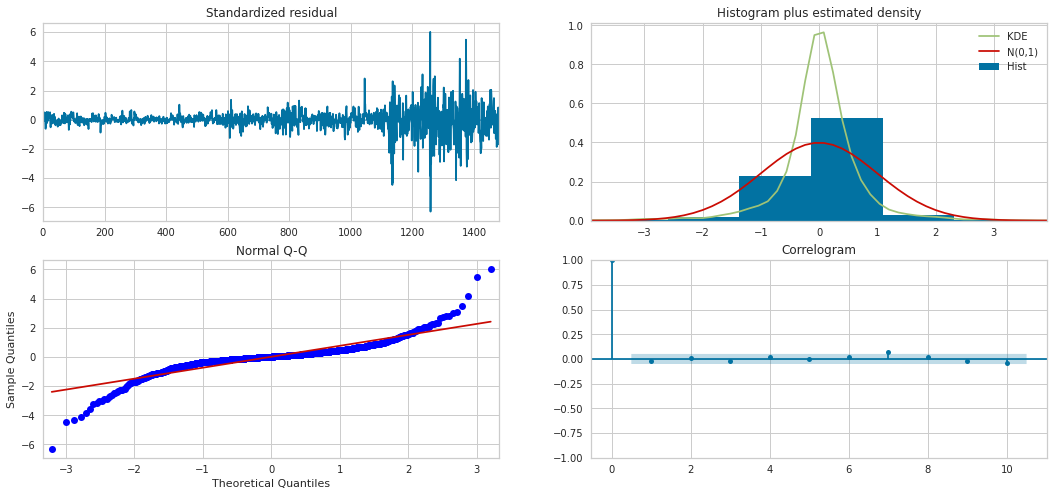

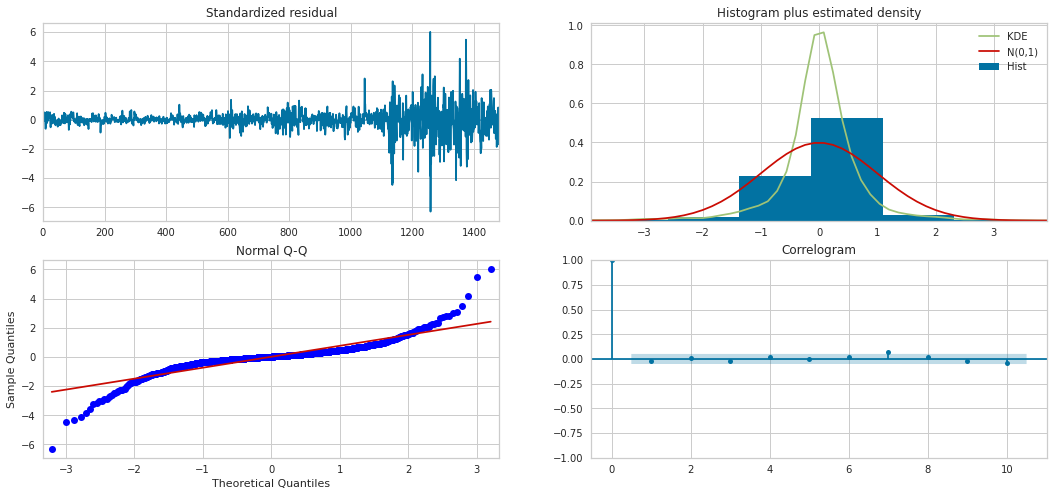

In [29]:
sxmodel.plot_diagnostics()

**In the Standarised Residual plot the residual errors seem to fluctuate around a mean of zero and have a uniform variance.**

**The density plot suggest normal distribution with mean zero.**

**All the points fall perfectly in line with the red line without much deviation in the QQ plot. Hence no significant deviations imply that the distribution is not skewed.**

**The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.**

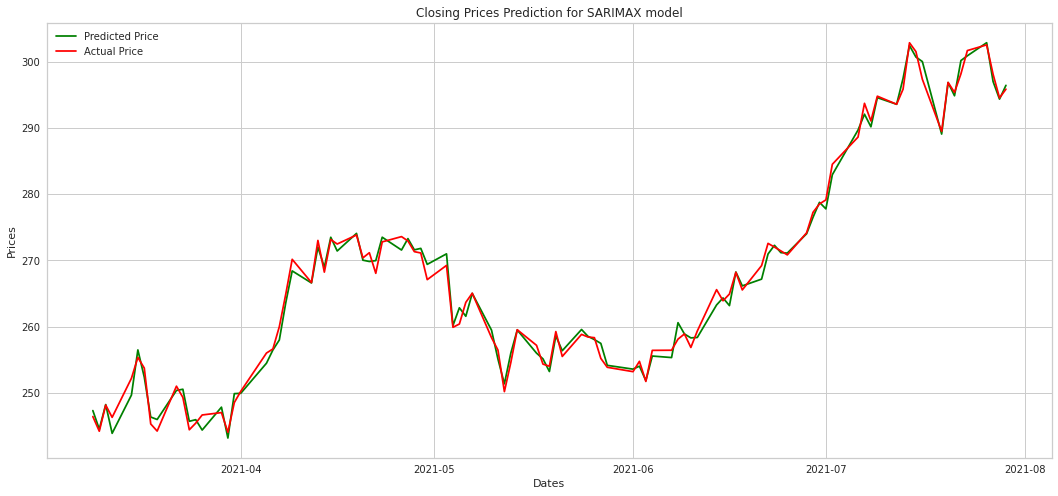

In [30]:
plt.plot(ds_train_date.iloc[1400:,-1:].index, yPredS, color='green',label='Predicted Price')
plt.plot(ds_train_date.iloc[1400:,-1:].index,ds_train_date.iloc[1400:,-1:] , color='red', label='Actual Price')
plt.title('Closing Prices Prediction for SARIMAX model')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

**The Above plot is the actual vs the predicted values of the closing price for the validation set obtained using the SARIMAX model**